In [2]:
colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    root = '/content/drive/MyDrive/colab/sat-images/'
    device = 'cuda'
    !wget -O sat.zip https://github.com/lacykaltgr/satellite-image-segmentation/archive/refs/heads/laci420.zip
    !unzip sat.zip
    !cp -r satellite-image-segmentation-laci420/src .
else:
    root = '/Users/czimbermark/DeepLearning_Projects_23/satellite-image-segmentation/data/'
    device = 'cpu'

In [3]:
import torch
from torch.utils.data import DataLoader
from src.dataset import XYDataset, load_dataset

x_train, y_train, x_val, y_val, x_test = load_dataset(root)

train_dataset = XYDataset(x_train, y_train, crop_size=256)
val_dataset = XYDataset(x_val, y_val, crop_size=256)
#test_dataset = XYDataset(x_test, torch.zeros(len(x_test)))

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
#test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
from src.model import UNet, EarlyStopper
unet = UNet().to(device)

In [4]:
es = EarlyStopper(patience=10)
unet.train_model(train_loader, val_loader, es, num_epochs=1000, learning_rate=0.0001, device=device)

RuntimeError: MPS backend out of memory (MPS allocated: 15.73 GB, other allocations: 2.35 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [20]:
predictions, results = unet.predict(train_loader, device=device)

RuntimeError: Invalid buffer size: 8.00 GB

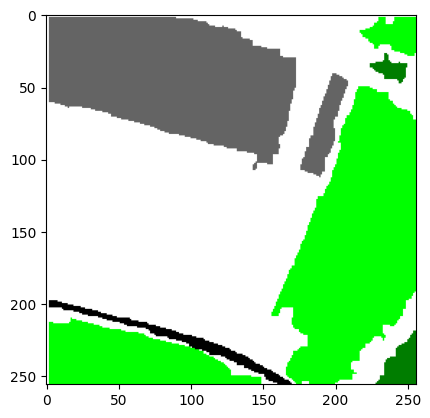

In [7]:
from matplotlib.pyplot import imshow, show
imshow(x)
show()

In [ ]:
from src.utils import conf_matrix
conf_matrix(val_dataset, results)

In [6]:
unet.load_state_dict(torch.load('/Users/czimbermark/DeepLearning_Projects_23/sat-img-seg-model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
import sys
sys.path.append('/path/to/DeepLearning_Projects_23/satellite-image-segmentation/')

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import imageio 

# Load image data into 'data' array (shape: h x w x band)
pil_img = imageio.read('/Users/czimbermark/DeepLearning_Projects_23/satellite-image-segmentation/data/The-Eye-in-the-Sky-test-data/sat_test/3.tif')
img_data = np.array(pil_img.get_data(0))
print(img_data.shape)   # (1217, 1692, 4)

(1217, 1692, 4)


In [9]:
from src.split import ImageProcessor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


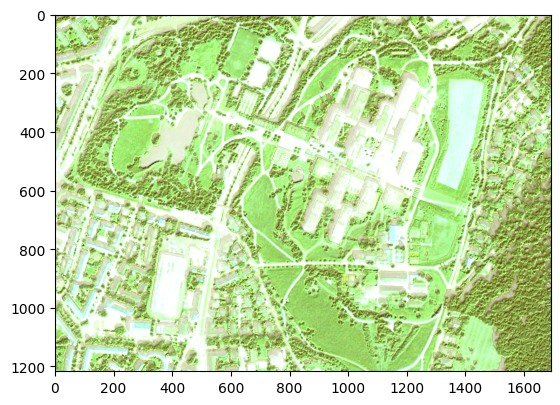

In [10]:
# Parameters:
w = 1692  # original width
h = 1217  # original height
band = 4  # number of bands (RGB)
size = 256  # window size (256x256)

# Create Image object and split the image into windows
img = ImageProcessor(w, h, band, size)
img.data = img_data

plt.imshow(img.data)

In [11]:
windows = img.split()

Padding: (63, 100)
Original Image Shape: (1217, 1692, 4)
Padded Image Shape: (1280, 1792, 4)


In [ ]:
eval = unet.evaluate(val_loader, device=device)